## CS 476 Assignment 4
#### Jeongseop Yi (Patrick), j22yi
#### Q2

In [71]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### a)

In [72]:
# butterfly option payoff function
def butterflyPayoff(S, K1, K3):
    K2 = (K1 + K3) / 2
    if np.isnan(S):
        return np.nan
    if S > K1 and S < K2:
        return S - K1
    elif S > K2 and S < K3:
        return K3 - S
    else:
        return 0

# sigma function
def sigma_func(S, alpha):
    return np.divide(alpha, np.sqrt(S), out=np.zeros_like(S), where=S!=0)

In [73]:
# upstream alpha beta calculation function
def upstream(S, sigma_func, r):
    Splus1 = np.roll(S, -1)
    Splus1[-1] = np.nan
    Sminus1 = np.roll(S, 1)
    Sminus1[0] = np.nan
    sigma = sigma_func(S)

    alpha_cen = (sigma**2*S**2 / ((S - Sminus1) * (Splus1 - Sminus1)) 
                 - (r * S) / (Splus1 - Sminus1))
    beta_cen = (sigma**2*S**2 / ((Splus1 - S) * (Splus1 - Sminus1)) 
                + (r * S) / (Splus1 - Sminus1))
    alpha_cen = np.nan_to_num(alpha_cen, copy=False)
    beta_cen = np.nan_to_num(beta_cen, copy=False)

    alpha_ret = np.zeros(len(S))
    beta_ret = np.zeros(len(S))
    for i in range(len(S)):
        if (alpha_cen[i] >= 0 and beta_cen[i] >= 0):
            alpha_ret[i] = alpha_cen[i]
            beta_ret[i] = beta_cen[i]
        else:
            alpha_for = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                      ((S[i] - Sminus1[i]) * (Splus1[i] - Sminus1[i])))
            beta_for = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                     ((Splus1[i] - S[i]) * (Splus1[i] - Sminus1[i])) 
                                     + (r * S[i]) / (Splus1[i] - Sminus1[i]))
            if (alpha_for >= 0 and beta_for >= 0):
                alpha_ret[i] = alpha_for
                beta_ret[i] = beta_for
            else:
                alpha_ret[i] = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                             ((S[i] - Sminus1[i]) * 
                                              (Splus1[i] - Sminus1[i])))
                beta_ret[i] = np.nan_to_num(sigma[i]**2*S[i]**2 / 
                                            ((Splus1[i] - S[i]) * 
                                             (Splus1[i] - Sminus1[i])) 
                                            + (r * S[i]) / (Splus1[i] - Sminus1[i]))
    return alpha_ret, beta_ret

In [74]:
# constant timestep American option pricing PDE function
# CN-Rannacher method
def Constant_Amer_CN(S, payoff, sigma, r, T, dt, tol):
    N = int(T / dt)
    V = np.zeros((N + 1, len(S)))
    V[0] = list(map(lambda x: payoff(x), S))
    large = 1 / tol
    for i in range(N):
        alpha, beta = upstream(S, sigma, r)
        M = [[], [], []]
        M[0] = -alpha*dt
        M[1] = (alpha + beta + r)*dt
        M[2] = -beta*dt
        M[0] = M[0][1:]
        M[2] = M[2][:len(S)-1]

        theta = 0
        if (i >= 2): theta = 0.5

        V[i+1] = V[i]
        Mdiag = sp.sparse.diags(M, [-1, 0, 1], format='csr')
        while (True): 
            P = sp.sparse.diags(np.where(V[i+1] < V[0], large, 0), 0, format='csr')
            M1 = sp.sparse.eye(len(S)) + (Mdiag * (1 - theta)) + P
            M2 = sp.sparse.eye(len(S)) - (Mdiag * theta)
            vi = M2 @ V[i] + P @ V[0]
            newsol = sp.sparse.linalg.spsolve(M1, vi)
            err = np.max(np.abs(newsol - V[i+1]) / 
                         np.where(np.abs(newsol) > 1, np.abs(newsol), 1))
            V[i+1] = newsol
            if (err < tol): break
    return V


In [75]:
# variable timestep American option pricing PDE function
# CN-Rannacher method
def Variable_Amer_CN(S, payoff, sigma, r, T, dt, tol, dnorm):
    N = int(T / dt)
    V = np.zeros((1, len(S)))
    V[0] = list(map(lambda x: payoff(x), S))
    large = 1 / tol
    curt = 0
    i = 0
    time = [0]
    while (curt < T):
        if (curt + dt > T): dt = T - curt
        alpha, beta = upstream(S, sigma, r)
        M = [[], [], []]
        M[0] = -alpha*dt
        M[1] = (alpha + beta + r)*dt
        M[2] = -beta*dt
        M[0] = M[0][1:]
        M[2] = M[2][:len(S)-1]
        
        theta = 0
        if (i >= 2): theta = 0.5

        V = np.append(V, [V[i]], axis=0)
        Mdiag = sp.sparse.diags(M, [-1, 0, 1], format='csr')
        while (True):
            P = sp.sparse.diags(np.where(V[i+1] < V[0], large, 0), 0, format='csr')
            M1 = sp.sparse.eye(len(S)) + (Mdiag * (1 - theta)) + P
            M2 = sp.sparse.eye(len(S)) - (Mdiag * theta)
            vi = M2 @ V[i] + P @ V[0]
            newsol = sp.sparse.linalg.spsolve(M1, vi)
            err = np.max(np.abs(newsol - V[i+1]) / 
                         np.where(np.abs(newsol) > 1, np.abs(newsol), 1))
            V[i+1] = newsol
            if (err < tol): break

        maxrelchange = np.max(np.abs(V[i+1] - V[i]) / 
                              np.where(np.abs(V[i+1]) > 1, np.abs(V[i+1]), 
                                       np.where(np.abs(V[i]) > 1, np.abs(V[i]), 1)))
        curt += dt
        time.append(curt)
        dt = (dnorm / maxrelchange) * dt
        i += 1
    return V, time

In [76]:
# helper function to refine the stock price grid
def double_S(S):
    SS = S.repeat(2)
    return (SS[1:] + SS[:-1]) / 2

# helper function to find the correct index
def index1(x):
    return int(np.log(x // 25) / np.log(2))

# helper function to find 
# the correct index of the stock price index
def index2(k, x):
    idx = index1(x)
    return k * 2 ** idx - 1 * 2 ** idx

In [77]:
# parameters from Table 1
S0 = 95
K = 100
K1 = 0.9 * S0
K3 = 1e7
r = 0.05
alpha = 2.5
T = 1
tol = 1e-6
dnorm = 0.1

S = np.concatenate([
    np.arange(0, 0.45*S0, 0.1*S0),
    np.arange(0.45*S0, 0.82*S0, 0.05*S0),
    np.arange(0.82*S0, 0.91*S0, 0.02*S0),
    np.arange(0.91*S0, 1.105*S0, 0.01*S0),
    np.arange(1.12*S0, 1.21*S0, 0.02*S0),
    np.arange(1.25*S0, 1.62*S0, 0.05*S0),
    np.arange(1.7*S0, 2.05*S0, 0.1*S0),
    np.array([2.2*S0, 2.4*S0, 2.8*S0, 3.6*S0, 5*S0, 7.5*S0, 10*S0]),
])

In [78]:
# create a dataframe to store the convergence results
conv_test1 = {'n': [25], 'len': [len(S)], 'dnorm': [dnorm]}
conv_test2 = {'n': [25], 'n4': [25], 'len': [len(S)], 'dnorm': [dnorm]}
S_list = [S]
for i in range(1, 5):
    conv_test1['n'].append(2 ** i * 25)
    conv_test1['len'].append(len(SS))
    conv_test1['dnorm'].append(2 ** (-i) * dnorm)
    conv_test2['n'].append(2 ** i * 25)
    conv_test2['n4'].append(4 ** i * 25)
    conv_test2['len'].append(len(SS))
    conv_test2['dnorm'].append(2 ** (-i) * dnorm)
    SS = double_S(S_list[i-1])
    S_list.append(SS)

conv_test1 = pd.DataFrame(conv_test1)
conv_test2 = pd.DataFrame(conv_test2)

##################################
# Constant
##################################
conv_test1['Dt'] = T / conv_test1['n']
conv_test1['Constant'] = conv_test1['n'].apply(
    lambda x: Constant_Amer_CN(S_list[index1(x)], 
                          lambda S: butterflyPayoff(S, K1, K3), 
                          lambda S: sigma_func(S, alpha), r, T, T/x, tol)
                          [-1][index2(28, x)])
conv_test1['Constant_Change'] = conv_test1['Constant'].diff()
conv_test1['Constant_Ratio'] = conv_test1['Constant_Change'].shift(1) \
    / conv_test1['Constant_Change']

##################################
# Variable
##################################
conv_test2['Dt'] = T / conv_test2['n']
conv_test2['Dt4'] = T / conv_test2['n4']
conv_test2['Variable'] = conv_test2['n'].apply(
    lambda x: Variable_Amer_CN(S_list[index1(x)], 
                               lambda S: butterflyPayoff(S, K1, K3), 
                               lambda S: sigma_func(S, alpha),
                               r, T, T/conv_test2['n4'][index1(x)], tol,
                               conv_test2['dnorm'][index1(x)])
                               [0][-1][index2(28, x)])
conv_test2['Variable_Change'] = conv_test2['Variable'].diff()
conv_test2['Variable_Ratio'] = conv_test2['Variable_Change'].shift(1) \
    / conv_test2['Variable_Change']

# show the results
display(conv_test1)
display(conv_test2)

,n,len,dnorm,Dt,Constant,Constant_Change,Constant_Ratio
0,25,62,0.10000,0.0400,17.602650,NaN,NaN
1,50,977,0.05000,0.0200,17.618596,0.015946,NaN
2,100,123,0.02500,0.0100,17.622606,0.004010,3.976950
3,200,245,0.01250,0.0050,17.623610,0.001004,3.992094
4,400,489,0.00625,0.0025,17.623861,0.000251,3.996902


,n,n4,len,dnorm,Dt,Dt4,Variable,Variable_Change,Variable_Ratio
0,25,25,62,0.10000,0.0400,0.040000,17.604219,NaN,NaN
1,50,100,977,0.05000,0.0200,0.010000,17.619317,0.015098,NaN
2,100,400,123,0.02500,0.0100,0.002500,17.622807,0.003491,4.325231
3,200,1600,245,0.01250,0.0050,0.000625,17.623662,0.000855,4.084986
4,400,6400,489,0.00625,0.0025,0.000156,17.623874,0.000212,4.021311


The butterfly spread becomes a call option as $K_3 \rightarrow \infty$. 
As $K_3 \rightarrow \infty$, $K_2 \rightarrow \infty$, so the bottom two condition of the butterfly function disappears. The remaining condition is exactly the same as the payoff function of a call of option with strike price at $K_1$. 

$$
\text{payoff}(S_T) = 
\begin{cases}
    0,  & \text{if } S_T \leq K_1 \\
    S_T - K_1,  & \text{if } K_1 < S_T \\ 
\end{cases}
$$

#### b)

In [79]:
# variable timestep European option pricing PDE function
# CN-Rannacher method
def Variable_Euro_CN(S, payoff, sigma, r, T, dt, tol, dnorm):
    N = int(T / dt)
    V = np.zeros((1, len(S)))
    V[0] = list(map(lambda x: payoff(x), S))
    large = 1 / tol
    curt = 0
    i = 0
    time = [0]
    while (curt < T):
        if (curt + dt > T): dt = T - curt
        alpha, beta = upstream(S, sigma, r)
        M = [[], [], []]
        M[0] = -alpha*dt
        M[1] = (alpha + beta + r)*dt
        M[2] = -beta*dt
        M[0] = M[0][1:]
        M[2] = M[2][:len(S)-1]
        
        theta = 0
        if (i >= 2): theta = 0.5

        V = np.append(V, [V[i]], axis=0)
        Mdiag = sp.sparse.diags(M, [-1, 0, 1], format='csr')
        while (True):
            M1 = sp.sparse.eye(len(S)) + (Mdiag * (1 - theta))
            M2 = sp.sparse.eye(len(S)) - (Mdiag * theta)
            vi = M2 @ V[i]
            newsol = sp.sparse.linalg.spsolve(M1, vi)
            err = np.max(np.abs(newsol - V[i+1]) / 
                         np.where(np.abs(newsol) > 1, np.abs(newsol), 1))
            V[i+1] = newsol
            if (err < tol): break

        maxrelchange = np.max(np.abs(V[i+1] - V[i]) / 
                              np.where(np.abs(V[i+1]) > 1, np.abs(V[i+1]), 
                                       np.where(np.abs(V[i]) > 1, np.abs(V[i]), 1)))
        curt += dt
        time.append(curt)
        dt = (dnorm / maxrelchange) * dt
        i += 1
    return V, time

[]

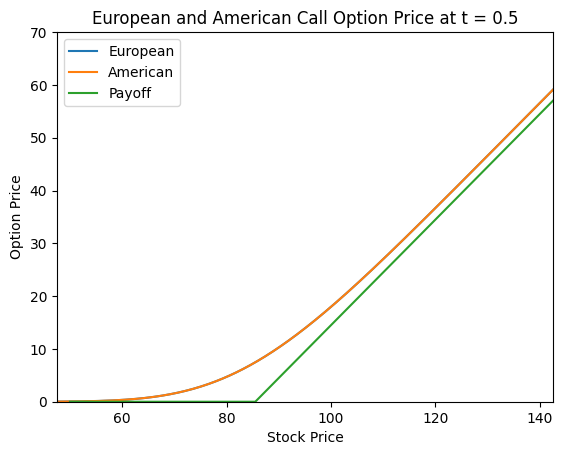

In [80]:
# calculate the European call option price
Euro, Euro_t = Variable_Euro_CN(S_list[-1],
            lambda S: butterflyPayoff(S, K1, K3),
            lambda S: sigma_func(S, alpha),
            r, T, T/conv_test2['n4'].iloc[-1], tol, dnorm)

# find the index where the time is 0.5
euro_idx = np.argmin(np.abs(np.array(Euro_t) - 0.5))

# calculate the European call option price
Amer, Amer_t = Variable_Amer_CN(S_list[-1],
            lambda S: butterflyPayoff(S, K1, K3),
            lambda S: sigma_func(S, alpha),
            r, T, T/conv_test2['n4'].iloc[-1], tol, dnorm)

# find the index where the time is 0.5
amer_idx = np.argmin(np.abs(np.array(Amer_t) - 0.5))

# plot the results
sns.lineplot(x=S_list[-1], y=Euro[euro_idx], label='European')
sns.lineplot(x=S_list[-1], y=Amer[amer_idx], label='American')
sns.lineplot(x=np.linspace(50, 150, 1000), 
             y=list(map(lambda x: butterflyPayoff(x, K1, K3), 
                        np.linspace(50, 150, 1000))), 
             label='Payoff')
plt.xlim(0.5*S0, 1.5*S0)
plt.ylim(0, 70)
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European and American Call Option Price at t = 0.5')
plt.plot()

The European and American call option values at $t = \frac{T}{2}$ are drawn above. The payoff function is also plotted in green. 

There is no difference in between the European and American call option values at $t = \frac{T}{2}$. It is not optimal to exercise the butterfly spread option (which is a call option as $K3 = \infty$), as there is no region that the payoff exceeds the American option price.

Actually, as $K3 = \infty$, the butterfly spread option here is a call option as discussed in q2a). Call option is never optimal to exercise early as it is explained in Lec 13 slide 11. European call option breaks the no-arbitrage property when the option value is set to be under the payoff function and American option value is always greater than or equal to its counterpart European option value. 

#### c)


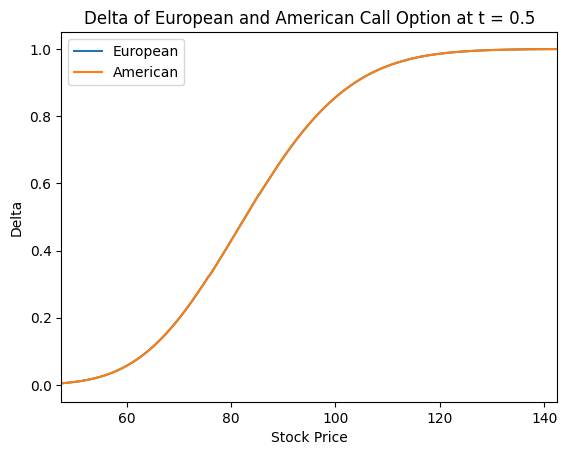

In [81]:
# Delta of the European and American option
delta_Euro = np.zeros((len(Euro), len(S_list[-1])))
delta_Amer = np.zeros((len(Amer), len(S_list[-1])))
for i in range(len(Euro)):
    Euro_i_s = np.roll(Euro[i-1], -1)
    Amer_i_s = np.roll(Amer[i-1], -1)
    Ss = np.roll(S_list[-1], -1)
    delta_Euro[i] = (Euro_i_s - Euro[i-1]) / (Ss - S_list[-1])
    delta_Amer[i] = (Amer_i_s - Amer[i-1]) / (Ss - S_list[-1])
ax = sns.lineplot(x=S_list[-1], y=delta_Euro[euro_idx], label='European')
sns.lineplot(x=S_list[-1], y=delta_Amer[amer_idx], label='American')
ax.set_xlim(0.5 * S0, 1.5 * S0)
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta of European and American Call Option at t = 0.5')
plt.show()

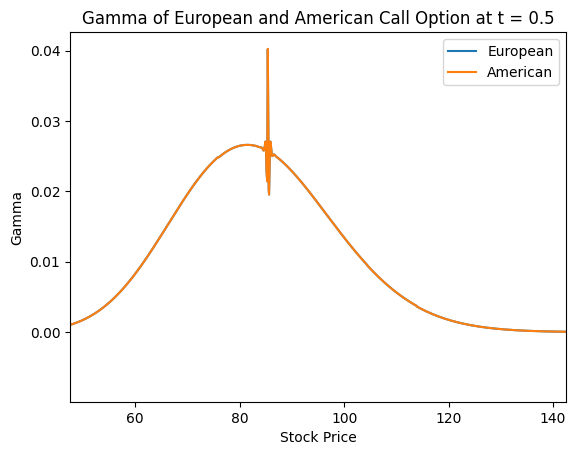

In [82]:
# gamma of the European and American option
gamma_Euro = np.zeros((len(Euro), len(S_list[-1])))
gamma_Amer = np.zeros((len(Amer), len(S_list[-1])))
for i in range(len(Euro)):
    G_Euro_i_s = np.roll(delta_Euro[i-1], -1)
    G_Amer_i_s = np.roll(delta_Amer[i-1], -1)
    Ss1 = np.roll(S_list[-1], -1)
    Ss2 = np.roll(S_list[-1], 0)
    diff = Ss1 - Ss2
    diff_avg = (diff + np.roll(diff, -1)) / 2
    gamma_Euro[i] = (G_Euro_i_s - delta_Euro[i-1]) / diff_avg
    gamma_Amer[i] = (G_Amer_i_s - delta_Amer[i-1]) / diff_avg

ax = sns.lineplot(x=S_list[-1], y=gamma_Euro[euro_idx], label='European')
sns.lineplot(x=S_list[-1], y=gamma_Euro[amer_idx], label='American')
ax.set_xlim(0.5 * S0, 1.5 * S0)
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma of European and American Call Option at t = 0.5')
plt.show()